## 1. Context & Problem Framing
The objective is to evaluate whether accident severity models trained on multiple U.S. cities generalize to a geographically unseen city (Boston). The focus is not maximizing in-sample accuracy, but testing cross-city robustness under distributional shift.

In [35]:
# --- Standard Data Handling and Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-Learn Model Selection and Preprocessing ---
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# --- Scikit-Learn Modeling ---
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, DMatrix

# --- Scikit-Learn Metrics and Evaluation ---
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)

### 1. Data Split Strategy (Cross-City Validation)

#### Load Preprocessed Data

In [3]:
%%time
!python ../scripts/preprocess.py

Loading data from ../data/raw/US_Accidents_March23.csv...
Saving processed data to ../data/processed\modeling_dataset_2016_2018.csv...
Done. Rows: 2,003,072, Columns: 10
CPU times: total: 1.33 s
Wall time: 10min


In [3]:
DATA_PATH = "../data/processed/modeling_dataset_2016_2018.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Severity2,CityState,Hour_Sin,Hour_Cos,Is_Weekend,Speed_Class,Precipitation(in),Visibility(mi),Temperature(F),Traffic_Signal
0,High,"Dayton, OH",0.965926,2.588190e-01,False,High_Speed,0.02,10.0,36.9,False
1,Low,"Reynoldsburg, OH",1.000000,6.123234e-17,False,Low_Speed,0.00,10.0,37.9,False
2,Low,"Williamsburg, OH",1.000000,6.123234e-17,False,Medium_Speed,0.00,10.0,36.0,True
3,High,"Dayton, OH",0.965926,-2.588190e-01,False,High_Speed,0.00,9.0,35.1,False
4,Low,"Dayton, OH",0.965926,-2.588190e-01,False,Low_Speed,0.00,6.0,36.0,True


In [4]:
(100 * df.isna().sum() / df.shape[0]).round(3)

Severity2            0.000
CityState            0.000
Hour_Sin             0.000
Hour_Cos             0.000
Is_Weekend           0.000
Speed_Class          0.000
Precipitation(in)    0.000
Visibility(mi)       2.350
Temperature(F)       1.915
Traffic_Signal       0.000
dtype: float64

#### Target/Features Definition
Our feature set is composed of the following:
- `Is_Weekend` (binary)
- `Traffic_Signal` (binary)
- `Speed_Class` (categorical)
- `Precipitation(in)` (numeric)
- `Temperature(F)` (numeric)
- `Visibility(mi)` (numeric)
- `Hour_Cos`, `Hour_Sin` (numeric)

In [6]:
TEST_CITY = "Boston, MA"

In [7]:
target = "Severity2"

groups = df.loc[df["CityState"] != TEST_CITY, "CityState"]  # Used for city-based cross-validation

num_feats = ["Precipitation(in)", "Visibility(mi)", "Temperature(F)"]
cat_feats = ["Speed_Class"]
bin_feats = ["Traffic_Signal", "Is_Weekend"]
hour_feats = ["Hour_Cos", "Hour_Sin"]

#### Train/Test Split (Boston Holdout)

In [8]:
train_df = df[df["CityState"] != TEST_CITY].copy()
test_df  = df[df["CityState"] == TEST_CITY].copy()

train_df.shape, test_df.shape

((2001620, 10), (1452, 10))

In [9]:
features = num_feats + cat_feats + bin_feats

X_train = train_df[features]
y_train = (train_df[target] == "High").astype(int)  # 1=High

X_test = test_df[features]
y_test = (test_df[target] == "High").astype(int)

In [11]:
y_train.value_counts(normalize=True).mul(100).round(2)

Severity2
0    64.68
1    35.32
Name: proportion, dtype: float64

In [12]:
y_test.value_counts(normalize=True).mul(100).round(2)

Severity2
0    63.71
1    36.29
Name: proportion, dtype: float64

### 2. Preprocessing & Model Setup

In [27]:
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
])

# We add a scaling of numerical values for linear models
numeric_pipe_scaled = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

### 3. Evaluation Methods

#### Validation: GroupKFold by City
To prevent geographic leakage, cross-validation is performed using GroupKFold with cities as groups. Boston is entirely excluded from training and used as a true geographic holdout to simulate deployment in an unseen city.

In [14]:
def crossval_by_city(model, X_train, y_train, groups, n_splits=5):
    cv = GroupKFold(n_splits=n_splits)

    scoring = {
        "f1": "f1",
        "precision": "precision",
        "recall": "recall",
        "roc_auc": "roc_auc",
        "avg_precision": "average_precision",
    }

    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv, groups=groups,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
        error_score="raise"
    )

    out = (
        pd.DataFrame(cv_results)
          .filter(like="test_")
          .agg(["mean", "std"])
          .T
          .rename_axis("metric")
    )

    out.index = out.index.str.replace("test_", "", regex=False)
    
    return out

#### Holdout Evaluation

In [30]:
def evaluate_holdout(y_true, pred, proba=None, report=False):
    if proba is not None:
        print(f"ROC-AUC: {roc_auc_score(y_true, proba):.3f}")
        print(f"PR-AUC : {average_precision_score(y_true, proba):.3f}")
    
    print(f"F1     : {f1_score(y_true, pred):.3f}")
    print(f"Precision: {precision_score(y_true, pred):.3f}")
    print(f"Recall   : {recall_score(y_true, pred):.3f}")

    if report:
        print("\nClassification report:")
        print(classification_report(y_true, pred, digits=3))

#### Confusion Matrix

In [16]:
def plot_confusion_matrix(y_true, pred, normalize="true", figsize=(8,5)):
    cm = confusion_matrix(y_true, pred, normalize=normalize)

    plt.figure(figsize=figsize)

    labels = ["Low", "High"]

    sns.heatmap(
        cm, 
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()

### 4. Baseline Model - Logistic Regression
A regularized logistic regression model is used as a baseline due to its interpretability and robustness under distribution shift.

#### Cross-City Validation

In [18]:
preprocess_logreg = ColumnTransformer([
    ("num", numeric_pipe_scaled, num_feats),
    ("cat", categorical_pipe, cat_feats),
    ("bin", "passthrough", bin_feats),
], remainder="drop")

logreg = Pipeline([
    ("prep", preprocess_logreg),
    ("model", LogisticRegression(
        max_iter=500, 
        class_weight="balanced"
    )),
])

cv_logreg = crossval_by_city(logreg, X_train, y_train, groups)

In [20]:
cv_logreg.round(3).T

metric,f1,precision,recall,roc_auc,avg_precision
mean,0.610,0.597,0.625,0.753,0.605
std,0.007,0.016,0.012,0.007,0.011


Cross-city validation shows stable performance across folds, with ROC-AUC ≈ 0.75 and F1 ≈ 0.61. Low standard deviation suggests consistent generalization across training cities.

#### Holdout Evaluation (Test) - Boston

In [21]:
logreg.fit(X_train, y_train)
logreg_proba = logreg.predict_proba(X_test)[:, 1]
logreg_pred = (logreg_proba >= 0.5).astype(int)

In [31]:
evaluate_holdout(y_test, logreg_pred, logreg_proba, report=False)

ROC-AUC: 0.801
PR-AUC : 0.688
F1     : 0.592
Precision: 0.729
Recall   : 0.499


In [25]:
confusion_matrix(y_test, logreg_pred, normalize="true").round(3)

array([[0.894, 0.106],
       [0.501, 0.499]])

On the geographically unseen Boston dataset, the model achieves ROC-AUC = 0.80 and PR-AUC = 0.69. Performance does not materially degrade relative to cross-validation, indicating successful cross-city generalization.

Recall remains lower than precision, suggesting conservative positive predictions under the default threshold.

### 5. Nonlinear Model - Gradient Boosting (XGBoost)
To test whether nonlinear interactions improve transfer performance, an XGBoost classifier is trained using the same cross-city protocol.

In [44]:
preprocess_xgb = ColumnTransformer([
    ("num", numeric_pipe, num_feats),
    ("cat", categorical_pipe, cat_feats),
    ("bin", "passthrough", bin_feats),
], remainder="drop")

xgb = Pipeline(steps=[
    ("prep", preprocess_xgb),
    ("model", XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        device="cuda",   # GPU
        random_state=42,
        n_jobs=-1
    ))
])

cv_xgb = crossval_by_city(xgb, X_train, y_train, groups)

In [45]:
cv_xgb.round(2).T

metric,f1,precision,recall,roc_auc,avg_precision
mean,0.60,0.62,0.57,0.76,0.61
std,0.01,0.02,0.02,0.01,0.01


In [46]:
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_proba >= 0.5).astype(int)

In [47]:
evaluate_holdout(y_test, xgb_pred, xgb_proba, report=False)

ROC-AUC: 0.801
PR-AUC : 0.689
F1     : 0.584
Precision: 0.741
Recall   : 0.482


In [48]:
confusion_matrix(y_test, xgb_pred, normalize="true").round(3)

array([[0.904, 0.096],
       [0.518, 0.482]])

XGBoost yields nearly identical ROC-AUC and F1 scores to logistic regression. The marginal improvement suggests that most predictive signal is linear or monotonic.

### 6. Model Comparison (Cross-City CV + Boston Holdout)

| Model                | CV F1 (mean±std) | CV ROC-AUC (mean±std) | CV PR-AUC (mean±std) | Boston ROC-AUC | Boston PR-AUC | Boston F1 | Boston Precision | Boston Recall |
|----------------------|------------------|------------------------|-----------------------|----------------|---------------|-----------|------------------|---------------|
| Logistic Regression  | 0.610 ± 0.007    | 0.753 ± 0.007          | 0.605 ± 0.011         | 0.801          | 0.688         | 0.592     | 0.729            | 0.499         |
| XGBoost              | 0.600 ± 0.010    | 0.760 ± 0.010          | 0.610 ± 0.010         | 0.801          | 0.689         | 0.584     | 0.741            | 0.482         |


Both models achieve comparable cross-city discrimination and Boston holdout performance; given similar results, logistic regression is preferred for interpretability and simplicity.

### 7. Threshold Optimization
Metrics such as precision, recall, and F1 depend on the classification threshold. The default 0.5 threshold may not reflect operational priorities.

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, logreg_proba)

In [51]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1: {f1_scores[best_idx]:.3f}")

Best threshold: 0.420
Best F1: 0.721


In [52]:
pred_opt = (logreg_proba >= best_threshold).astype(int)

In [53]:
evaluate_holdout(y_test, pred_opt, logreg_proba, report=False)

ROC-AUC: 0.801
PR-AUC : 0.688
F1     : 0.721
Precision: 0.673
Recall   : 0.776


In [55]:
confusion_matrix(y_test, pred_opt, normalize="true").round(2)

array([[0.78, 0.22],
       [0.22, 0.78]])

### 8. Feature Importance / Coefficient Interpretation
We examine feature importance using both Logistic Regression and XGBoost. Logistic regression coefficients provide clear directional interpretation of each feature’s effect on high-severity risk, while XGBoost importance scores serve as a robustness check to confirm that key predictors remain influential under a non-linear modeling framework.

#### Logistic Regression

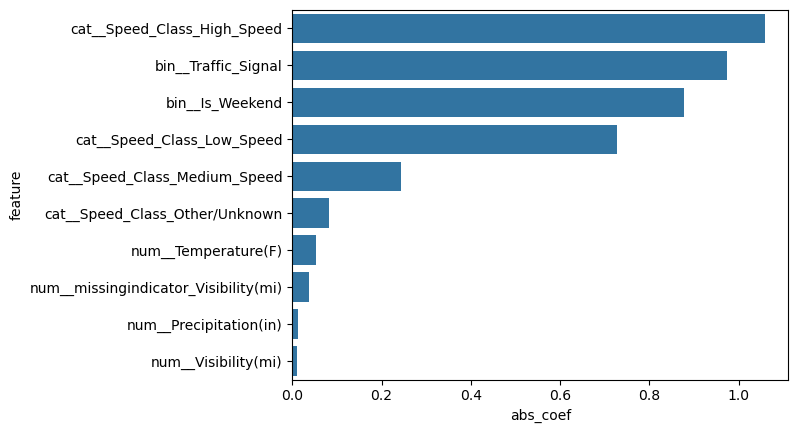

In [61]:
model = logreg.named_steps["model"]
prep = logreg.named_steps["prep"]

feature_names = prep.get_feature_names_out()
coefs = model.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

sns.barplot(data=coef_df.head(10), x="abs_coef", y="feature")
plt.show()

Logistic coefficients confirm that high-speed roads are the strongest predictor of high-impact accidents, followed by adverse weather and nighttime conditions.

#### XGBoost

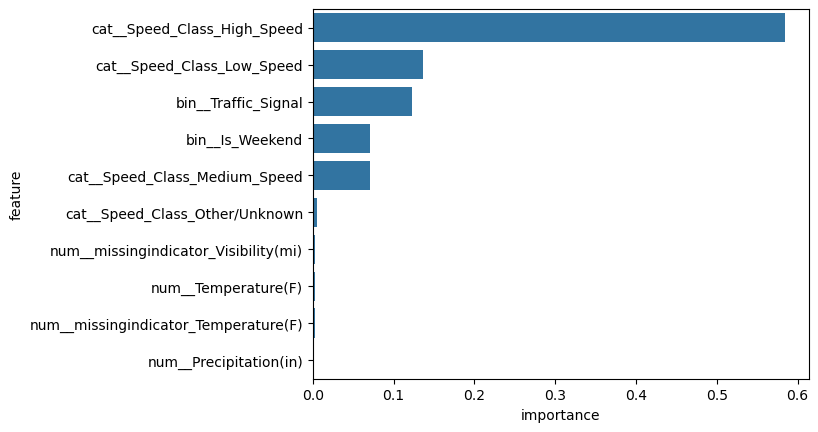

In [62]:
xgb_model = xgb.named_steps["model"]
importances = xgb_model.feature_importances_

feature_names = xgb.named_steps["prep"].get_feature_names_out()

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

sns.barplot(data=fi_df.head(10), x="importance", y="feature")
plt.show()

Feature importance rankings align with audit findings, with `Speed_Class` and weather-related variables contributing most strongly.

### 9. Conclusion
This study demonstrates that accident severity models trained across multiple cities can generalize effectively to an unseen city when features are engineered to capture transferable structural signals (e.g., road speed environment, weather, temporal factors).

Model complexity provides limited additional benefit beyond well-designed features. Cross-city validation confirms robustness under geographic distribution shift.

#### Limitations
Severity labels may contain reporting bias, and unobserved variables (e.g., traffic volume, enforcement, road design) may limit predictive ceiling. Results reflect structured correlations rather than causal inference.

In [63]:
import joblib

joblib.dump(logreg, "../models/logreg_2016_2018.pkl")

['../models/logreg_2016_2018.pkl']

### Appendix A — Stress Test: Boston Under Temporal Drift (2019–2023)
This appendix evaluates temporal robustness by applying the final 2016–2018 trained model to newer Boston records (2019–2023). Because earlier audits showed label drift after 2018, results are interpreted as a stress test under distribution shift rather than a direct continuation of the main benchmark.

#### Load Preprocessed Post-2018 Data

In [66]:
%%time
!python ../scripts/preprocess.py --post --boston

Loading data from ../data/raw/US_Accidents_March23.csv...CPU times: total: 234 ms
Wall time: 1min 59s

Saving processed data to ../data/processed\modeling_dataset_2019_2023_Boston.csv...
Done. Rows: 3,332, Columns: 10


In [69]:
DATA_PATH = "../data/processed/modeling_dataset_2019_2023_Boston.csv"
boston_new = pd.read_csv(DATA_PATH)
boston_new.head(3)

,Severity2,CityState,Hour_Sin,Hour_Cos,Is_Weekend,Speed_Class,Precipitation(in),Visibility(mi),Temperature(F),Traffic_Signal
0,Low,"Boston, MA",0.866025,-0.5,False,Low_Speed,0.0,10.0,66.0,True
1,Low,"Boston, MA",0.866025,-0.5,False,Low_Speed,0.0,10.0,66.0,False
2,Low,"Boston, MA",-0.866025,-0.5,False,Low_Speed,0.0,10.0,69.0,False


In [70]:
boston_new["Severity2"].value_counts(normalize=True).mul(100).round(2)

Severity2
Low     74.16
High    25.84
Name: proportion, dtype: float64

#### Train/Test Split

In [72]:
boston_new_df  = boston_new[boston_new["CityState"] == TEST_CITY].copy()
X_boston_new = boston_new_df[features]
y_boston_new = (boston_new_df[target] == "High").astype(int)

#### Model Evaluation

In [73]:
model = joblib.load("../models/logreg_2016_2018.pkl")

In [75]:
THRESHOLD = 0.42
proba = model.predict_proba(X_boston_new)[:, 1]
pred = (proba >= THRESHOLD).astype(int)

In [77]:
evaluate_holdout(y_boston_new, pred, proba, report=False)

ROC-AUC: 0.790
PR-AUC : 0.539
F1     : 0.599
Precision: 0.506
Recall   : 0.735


In [78]:
confusion_matrix(y_boston_new, pred, normalize="true").round(3)

array([[0.749, 0.251],
       [0.265, 0.735]])

The model maintains strong ranking performance (ROC-AUC = 0.790), indicating stable feature–severity relationships over time. The decline in precision is consistent with the reduced share of high-severity cases (~26%), suggesting base-rate shift rather than model failure.

#### Conclusion
The model generalizes reasonably well across time, though threshold recalibration is required under changing class prevalence.